In [11]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
import copy
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
import math


In [2]:
model_path = "liuhaotian/llava-v1.5-7b"
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path)
)

/home/users/mxy/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
vision_model = copy.deepcopy(model.model.vision_tower); vision_model.eval()
# In llava, the forward function of CLIP is wrapped with torch.no_grad, which we get rid of below
image_encoder_ = vision_model.forward.__wrapped__
image_encoder = lambda x: image_encoder_(vision_model, x)

In [12]:
def pad_to_square(image: Image.Image) -> Image.Image:
    """
    Pads an image to a square with the nearest multiple of 16
    of the longest dimension, ensuring the image is centered.
    """
    width, height = image.size
    max_dim = max(width, height)
    
    # Find the nearest multiple of 16 greater than or equal to max_dim
    target_size = math.ceil(max_dim / 16) * 16

    # Compute padding for both dimensions
    padding_left = (target_size - width) // 2
    padding_right = target_size - width - padding_left
    padding_top = (target_size - height) // 2
    padding_bottom = target_size - height - padding_top

    # Apply padding using TF.pad
    padded_image = TF.pad(
        image, 
        padding=(padding_left, padding_top, padding_right, padding_bottom),
        fill=0  # Black padding
    )
    
    return padded_image

In [24]:
class mathvista_transform:
    def __init__(self, img_size, fill_color=(255, 255, 255)):
        self.img_size = img_size
        self.fill_color = fill_color

    def __call__(self, img):
        # Get original image size
        width, height = img.size

        # Calculate padding to make the image square
        if width > height:
            padding_top = (width - height) // 2
            padding_bottom = width - height - padding_top
            padding_left = padding_right = 0
        else:
            padding_left = (height - width) // 2
            padding_right = height - width - padding_left
            padding_top = padding_bottom = 0

        # Pad the image to make it square
        img = TF.pad(img, (padding_left, padding_top, padding_right, padding_bottom), fill=self.fill_color)

        # Resize the image to the desired size using bicubic interpolation
        img = TF.resize(img, (self.img_size, self.img_size), interpolation=Image.BICUBIC)

        return img

In [30]:
resize_fn = mathvista_transform(224)

image_path1 = "/usr/xtmp/mxy/VLM-Poisoning/data/task_data/MathVista_base_hamburgerFries_target/base_train/6141.jpg"
img1 = Image.open(image_path1).convert('RGB')
img1 = transforms.ToTensor()(resize_fn(img1)).unsqueeze(0)

image_path2 = "/usr/xtmp/mxy/VLM-Poisoning/data/task_data/MathVista_base_hamburgerFries_target/base_train/6138.jpg"
img2 = Image.open(image_path2).convert('RGB')
img2 = transforms.ToTensor()(resize_fn(img2)).unsqueeze(0)

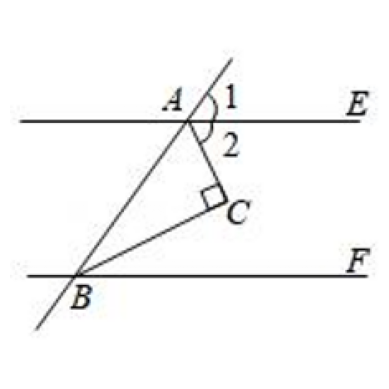

In [31]:
import matplotlib.pyplot as plt 

def show_image(img_tensor):
    """Display a tensor image using matplotlib."""
    img = img_tensor.squeeze(0).permute(1, 2, 0)  # Convert from CHW to HWC
    plt.imshow(img)
    plt.axis('off')  # Hide axis for cleaner display
    plt.show()

image_path2 = "/usr/xtmp/mxy/VLM-Poisoning/data/task_data/MathVista_base_hamburgerFries_target/base_train/6138.jpg"
img2 = Image.open(image_path2).convert('RGB')
img2 = transforms.ToTensor()(resize_fn(img2)).unsqueeze(0)
show_image(img2)


In [32]:
img1.size()

torch.Size([1, 3, 224, 224])

In [33]:
out_1 = image_encoder(img1)

RuntimeError: The size of tensor a (257) must match the size of tensor b (577) at non-singleton dimension 1

In [11]:
import torch
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
import bitsandbytes as bnb
from accelerate import Accelerator
from accelerate.utils import gather_object
from parallelformers import parallelize
import warnings
from PIL import Image
import torchvision
import copy

In [2]:
model_name="internlm/internlm-xcomposer2d5-7b"
num_beams=3
patience=1000000
sleep_time=0
d_type=torch.float16
warnings.filterwarnings("ignore")

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Use 8-bit quantization
    llm_int8_threshold=200.0  # Adjust threshold for 8-bit quantization if necessary
)

model = AutoModel.from_pretrained(
    model_name, 
    torch_dtype=d_type, 
    # quantization_config=quantization_config,
    trust_remote_code=True, 
    device_map='auto'
)

# model.eval()

# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# model.tokenizer = self.tokenizer

# def get_response(self, image_path, user_prompt):
#     query = user_prompt
#     with torch.no_grad():
#         with torch.autocast(device_type='cuda', dtype=self.d_type):
#         # with self.accelerator.autocast():
#             response, his = self.model.chat(self.tokenizer, query, [image_path], do_sample=False, num_beams=self.num_beams, use_meta=True)
#     prediction = response.strip()
#     return prediction


Set max length to 16384


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
def __resize_img__( b):
        width, height = b.size
        tar = max(width, height)
        top_padding = int((tar - height)/2)
        bottom_padding = tar - height - top_padding
        left_padding = int((tar - width)/2)
        right_padding = tar - width - left_padding
        b = torchvision.transforms.functional.pad(b, [left_padding, top_padding, right_padding, bottom_padding])
        return b

In [22]:
image_path = "/usr/xtmp/mxy/VLM-Poisoning/data/task_data/MathVista_base_hamburgerFries_target/base_train/12.jpg"

image = Image.open(image_path).convert('RGB')
image = __resize_img__(image)
image = model.vis_processor(image).unsqueeze(0).cuda()
image = torch.nn.functional.interpolate(image.float(), size=(560,560), mode='bicubic',).to(torch.float16)
image_embeds = model.img2emb(image)

In [38]:
image_embeds.size()

torch.Size([1, 841, 4096])

In [29]:
image.size()

torch.Size([1, 3, 640, 640])

In [32]:
torch.nn.functional.interpolate(image.float(), size=(560,560), mode='bicubic',).size()

torch.Size([1, 3, 560, 560])

In [15]:
vision_model = copy.deepcopy(model.vit)
vision_model.eval()
# In llava, the forward function of CLIP is wrapped with torch.no_grad, which we get rid of below
image_encoder_ = vision_model.forward.__wrapped__
image_encoder = lambda x: image_encoder_(vision_model, x)

AttributeError: 'function' object has no attribute '__wrapped__'

In [19]:
model.encode_img(image)

tensor([[[-0.0737, -0.2678,  0.5894,  ..., -0.3569, -0.4646,  0.7524],
         [-0.2258, -0.8555,  0.2844,  ..., -0.1205, -0.0971,  1.1445],
         [ 0.3350, -0.7505,  0.0291,  ..., -0.2947, -0.3474,  0.5127],
         ...,
         [-0.7178, -1.4160, -0.1115,  ..., -0.6279, -0.3542,  0.9375],
         [-0.4990, -0.6445,  0.6016,  ..., -0.2771, -0.8799,  0.8140],
         [ 0.0054,  0.0080, -0.0134,  ...,  0.0345, -0.0063, -0.0129]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ViewBackward0>)